<img width="10%" alt="Naas" src="https://landen.imgix.net/jtci2pxwjczr/assets/5ice39g4.png?w=160"/>

# YahooFinance - Chat about [ENTITY] trends and predictions

**Tags:** #yahoo #finance #ai #chat #plugin #python

**Author:** [Jeremy Ravenel](https://www.linkedin.com/in/jeremyravenel/)

**Description:** This notebook will generate an Naas Chat plugin for YahooFinance. It uses Python to access the YahooFinance API, NewsAPI, create one big table with actual, predictions, news, and sentiment and output a plugin that can be used to answer questions about the stock performance.

**References:**
- [YahooFinance Naas driver](https://pypi.org/project/naas-drivers/)
- [NLTK for sentiment analysis](https://github.com/cjhutto/vaderSentiment)
- [NewsAPI for latest news query](https://newsapi.org/docs)
- [OpenAI API](https://platform.openai.com/docs/introduction)

## Input

### Import libraries

In [83]:
import os
from os import path
import naas
import pandas as pd
from naas_drivers import prediction, yahoofinance, plotly, newsapi
import plotly.graph_objects as go
import markdown2
from datetime import datetime
from IPython.core.display import display, HTML
try: 
    import nltk
except:
    !pip install nltk --user
    import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
try:
    import tiktoken
except:
    !pip install tiktoken --user
    import tiktoken

### Setup variables

In [74]:
# Mandatory
ticker_name = "Amazon"
ticker = "AMZN"
index_name = "Nasdaq" #in this case Nasdaq
index = "^IXIC" #in this case Nasdaq

# Optional
date_from = -270
date_to = "today"
data_points = 90 #number of data points predicted in the future
output_dir = "."
now = datetime.now().strftime("%Y-%m-%d")
csv_output = path.join(output_dir,f"{now}_{ticker}.csv")
image_output = path.join(output_dir,f"{now}_{ticker}.png")
html_output = path.join(output_dir,f"{now}_{ticker}.html")
tracker_output = path.join(output_dir,f"{now}_{ticker}_tracker.csv")

## Model

### Get dataset from Yahoo Finance

In [28]:
# Get the Stock data
df_yahoo = yahoofinance.get(
    tickers=ticker,
    date_from=date_from,
    date_to=date_to
).dropna().reset_index(drop=True)

# Calculate the rolling minimum and maximum values of the 'total_predict' column
df_yahoo['min_rolling'] = df_yahoo['Close'].rolling(window=20).min()
df_yahoo['max_rolling'] = df_yahoo['Close'].rolling(window=20).max()

# Capitalize all column names
df_yahoo.columns = df_yahoo.columns.str.upper()

# Display dataframe
df_yahoo.tail(5)

,DATE,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,TICKER,MIN_ROLLING,MAX_ROLLING
181,2023-08-25,132.470001,133.869995,130.580002,133.259995,133.259995,44124800,AMZN,128.210007,142.220001
182,2023-08-28,133.779999,133.949997,131.850006,133.139999,133.139999,34083100,AMZN,128.210007,142.220001
183,2023-08-29,133.380005,135.139999,133.250000,134.910004,134.910004,38646100,AMZN,128.210007,142.220001
184,2023-08-30,134.929993,135.679993,133.919998,135.070007,135.070007,36061900,AMZN,128.910004,142.220001
185,2023-08-31,135.059998,138.788498,135.029999,137.804993,137.804993,25829537,AMZN,131.839996,142.220001


### Add relative index data

In [32]:
# Get the Index data
relative_index_data = yahoofinance.get(
    tickers=index,
    date_from=date_from,
    date_to=date_to
).dropna().reset_index(drop=True)

# Calculate the relative strength
df_yahoo['RELATIVE_INDEX'] = relative_index_data['Close']
df_yahoo['RELATIVE_STRENGTH_BASE'] = (df_yahoo['CLOSE'] / nasdaq_data['Close']) 
# Calculate the relative strength percentage
df_yahoo['RELATIVE_STRENGTH'] = df_yahoo['CLOSE'] * ( 1 - df_yahoo['RELATIVE_STRENGTH_BASE'])

# Display dataframe
df_yahoo.tail(5)

,DATE,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,TICKER,MIN_ROLLING,MAX_ROLLING,RELATIVE_INDEX,RELATIVE_STRENGTH_BASE,RELATIVE_STRENGTH
181,2023-08-25,132.470001,133.869995,130.580002,133.259995,133.259995,44124800,AMZN,128.210007,142.220001,13590.650391,0.009805,131.953345
182,2023-08-28,133.779999,133.949997,131.850006,133.139999,133.139999,34083100,AMZN,128.210007,142.220001,13705.129883,0.009715,131.846596
183,2023-08-29,133.380005,135.139999,133.250000,134.910004,134.910004,38646100,AMZN,128.210007,142.220001,13943.759766,0.009675,133.604710
184,2023-08-30,134.929993,135.679993,133.919998,135.070007,135.070007,36061900,AMZN,128.910004,142.220001,14019.309570,0.009635,133.768666
185,2023-08-31,135.059998,138.788498,135.029999,137.804993,137.804993,25829537,AMZN,131.839996,142.220001,14073.390625,0.009791,136.455772


### Create tracker data

In [35]:
def get_variation(df, ticker):
    df_yahoo = df.sort_values("DATE", ascending=False).reset_index(drop=True)

    # Get value and date comp
    datanow = df_yahoo.loc[0, "CLOSE"]
    date_now = df_yahoo.loc[0, "DATE"]
    datayesterday = df_yahoo.loc[1, "CLOSE"]

    # Calc variation in value and %
    varv = datanow - datayesterday
    varp = (varv / datanow) * 100

    # Get min and max value
    min_value = df_yahoo["CLOSE"].min()
    max_value = df_yahoo["CLOSE"].max()
    
    # Calculate the score
    score = 0 + ((10 - 0) * (datanow - min_value) / (max_value - min_value))

    # Format result
    datanow = "${:,.2f}".format(round(datanow, 1))
    datayesterday = "${:,.2f}".format(round(datayesterday, 1))
    varv = "{:+,.2f}".format(varv)
    varp = "{:+,.2%}".format(varp / 100)  # dividing by 100 to undo the earlier multiplication by 100
    min_value = "${:,.2f}".format(round(min_value, 1))
    max_value = "${:,.2f}".format(round(max_value, 1))

    # Create a DataFrame to hold the results
    result_df = pd.DataFrame({
        "ENTITY": "Universal Tracker",
        "SCENARIO": [date_now],
        "INDICATOR": [ticker],
        "TYPE": "Financial",
        "SOURCE": "Yahoo Finance",
        "VALUE": [datanow],
        "MIX": [min_value],
        "MAX": [max_value],
        "SCORE": [round(score, 2)]
    })

    return result_df

df_tracker = get_variation(df_yahoo, ticker)
df_tracker

,ENTITY,SCENARIO,INDICATOR,TYPE,SOURCE,VALUE,MIX,MAX,SCORE
0,Universal Tracker,2023-08-31,AMZN,Financial,Yahoo Finance,$137.80,$81.80,$142.20,9.27


### Add prediction

In [38]:
df_predict = prediction.get(
    dataset=df_yahoo,
    date_column='DATE',
    column="CLOSE",
    data_points=data_points,
    prediction_type="all"
).sort_values("DATE", ascending=False).reset_index(drop=True)

# Create 'TOTAL_PREDICT' column
df_predict['TOTAL_PREDICT'] = df_predict['LINEAR'].where(df_predict['LINEAR'].notna(), df_predict['CLOSE'])

# Calculate the 20 and 50 day moving averages
df_predict['MA05'] = df_predict['TOTAL_PREDICT'].rolling(window=5).mean()
df_predict['MA10'] = df_predict['TOTAL_PREDICT'].rolling(window=10).mean()
df_predict['MA50'] = df_predict['TOTAL_PREDICT'].rolling(window=50).mean()

# Display dataframe
df_predict.head(int(data_points)+5)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=847.696, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=848.028, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=847.388, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=847.798, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=846.061, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=847.621, Time=0.41 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=847.225, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=848.249, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=847.741, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.826 seconds


,DATE,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,TICKER,MIN_ROLLING,MAX_ROLLING,...,RELATIVE_STRENGTH_BASE,RELATIVE_STRENGTH,ARIMA,LINEAR,SVR,COMPOUND,TOTAL_PREDICT,MA05,MA10,MA50
0,2023-11-29,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,159.891480,178.333339,120.631067,152.951962,178.333339,NaN,NaN,NaN
1,2023-11-28,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,159.638364,174.799767,120.631067,151.689733,174.799767,NaN,NaN,NaN
2,2023-11-27,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,159.385248,174.593045,120.631067,151.536453,174.593045,NaN,NaN,NaN
3,2023-11-26,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,159.132132,172.306218,120.631067,150.689806,172.306218,NaN,NaN,NaN
4,2023-11-25,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,158.879016,172.461251,120.631067,150.657111,172.461251,174.498724,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2023-08-31,135.059998,138.788498,135.029999,137.804993,137.804993,25829537.0,AMZN,131.839996,142.220001,...,0.009791,136.455772,137.804993,137.804993,137.804993,137.804993,137.804993,137.049397,135.723037,152.913878
91,2023-08-30,134.929993,135.679993,133.919998,135.070007,135.070007,36061900.0,AMZN,128.910004,142.220001,...,0.009635,133.768666,NaN,NaN,NaN,NaN,135.070007,136.757191,135.549801,152.240471
92,2023-08-29,133.380005,135.139999,133.250000,134.910004,134.910004,38646100.0,AMZN,128.210007,142.220001,...,0.009675,133.604710,NaN,NaN,NaN,NaN,134.910004,135.303785,135.575036,151.567999
93,2023-08-28,133.779999,133.949997,131.850006,133.139999,133.139999,34083100.0,AMZN,128.210007,142.220001,...,0.009715,131.846596,NaN,NaN,NaN,NaN,133.139999,134.747023,135.468490,150.856509


### Get news data

In [42]:
df_news = newsapi.connect().get(
    f"{NAME}", 
    fields=["date","title", "image", "link", "description"]
)
df_news['date'] = pd.to_datetime(df_news['date']).dt.date
df_news = df_news.dropna()
df_news

,date,title,image,link,description
2,2023-08-28,Amazon Has Buy-One-Get-One-Free Video Games Ri...,https://i.kinja-img.com/gawker-media/image/upl...,https://lifehacker.com/amazon-has-buy-one-get-...,Amazon has listed hundreds of video games as “...
3,2023-08-19,Apple Will Finally Pay for Throttling iPhones ...,https://media.wired.com/photos/64dfcd35c65d33e...,https://www.wired.com/story/apple-batterygate-...,"Plus: Amazon Music gets pricier, a bunch of pe..."
9,2023-08-14,Amazon adds AI-generated review summaries so y...,https://cdn.vox-cdn.com/thumbor/PvTs1AQvbet47Q...,https://www.theverge.com/2023/8/14/23831391/am...,Amazon is rolling out generative AI product su...
10,2023-08-20,"In Good Omens, diversity is divine",https://cdn.vox-cdn.com/thumbor/oYJvdsLt6FowuD...,https://www.theverge.com/2023/8/20/23837230/go...,The second season of Amazon Prime’s Good Omens...
11,2023-08-16,Amazon Now Punishes Merchants Who Ship Their O...,https://i.kinja-img.com/gawker-media/image/upl...,https://gizmodo.com/amazon-adds-2-fee-for-merc...,Third-party merchants on Amazon who ship their...
12,2023-08-25,The Anticlimactic Death of the Streaming Wars,https://media.wired.com/photos/64e7d440a55c20b...,https://www.wired.com/story/netflix-amazon-dis...,Productions are grinding to a halt and Netflix...
13,2023-08-08,How to set up a Matter-over-Thread device in y...,https://cdn.vox-cdn.com/thumbor/uULaeZsvwF11uC...,https://www.theverge.com/23823041/matter-threa...,A step-by-step guide to what you need to know ...
14,2023-08-29,Grubhub is bringing Amazon’s cashierless tech ...,https://cdn.vox-cdn.com/thumbor/EBU6KcuoH7Frlw...,https://www.theverge.com/2023/8/29/23848893/gr...,Grubhub’s partnering with Amazon to bring its ...
15,2023-08-10,12 Comedy Podcasts As Smart as SmartLess,https://i.kinja-img.com/gawker-media/image/upl...,https://lifehacker.com/best-funny-conversation...,SmartLess is having a good year. Jason Bateman...
17,2023-08-01,Amazon's Virtual Healthcare Is Now Available 2...,https://i.kinja-img.com/gawker-media/image/upl...,https://gizmodo.com/amazons-virtual-clinic-now...,Amazon is expanding its repertoire of services...


### Analyze sentiment per news article

In [44]:
# Dowload varder/nltk lexicon to perform sentiment analysis
nltk.download('vader_lexicon') 

# Create sentiment analysis
def analyze_sentiment(df, columns):
    sid = SentimentIntensityAnalyzer()

    for column in columns:
        new_cols = [
            f'{column}_neg', 
            f'{column}_neu', 
            f'{column}_pos', 
            f'{column}_compound'
        ]
        df[new_cols] = df[column].apply(lambda x: pd.Series(sid.polarity_scores(x)))
    return df

# Call the function
df_sentiment = analyze_sentiment(df_news, ['title', 'description'])
df_sentiment

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ftp/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,date,title,image,link,description,title_neg,title_neu,title_pos,title_compound,description_neg,description_neu,description_pos,description_compound
2,2023-08-28,Amazon Has Buy-One-Get-One-Free Video Games Ri...,https://i.kinja-img.com/gawker-media/image/upl...,https://lifehacker.com/amazon-has-buy-one-get-...,Amazon has listed hundreds of video games as “...,0.000,0.779,0.221,0.1779,0.039,0.900,0.061,0.0258
3,2023-08-19,Apple Will Finally Pay for Throttling iPhones ...,https://media.wired.com/photos/64dfcd35c65d33e...,https://www.wired.com/story/apple-batterygate-...,"Plus: Amazon Music gets pricier, a bunch of pe...",0.135,0.865,0.000,-0.1027,0.130,0.761,0.109,-0.3818
9,2023-08-14,Amazon adds AI-generated review summaries so y...,https://cdn.vox-cdn.com/thumbor/PvTs1AQvbet47Q...,https://www.theverge.com/2023/8/14/23831391/am...,Amazon is rolling out generative AI product su...,0.000,0.876,0.124,0.1779,0.000,0.909,0.091,0.1779
10,2023-08-20,"In Good Omens, diversity is divine",https://cdn.vox-cdn.com/thumbor/oYJvdsLt6FowuD...,https://www.theverge.com/2023/8/20/23837230/go...,The second season of Amazon Prime’s Good Omens...,0.000,0.381,0.619,0.7579,0.000,0.719,0.281,0.8020
11,2023-08-16,Amazon Now Punishes Merchants Who Ship Their O...,https://i.kinja-img.com/gawker-media/image/upl...,https://gizmodo.com/amazon-adds-2-fee-for-merc...,Third-party merchants on Amazon who ship their...,0.263,0.593,0.144,-0.3400,0.000,0.937,0.063,0.1779
12,2023-08-25,The Anticlimactic Death of the Streaming Wars,https://media.wired.com/photos/64e7d440a55c20b...,https://www.wired.com/story/netflix-amazon-dis...,Productions are grinding to a halt and Netflix...,0.600,0.400,0.000,-0.8176,0.126,0.824,0.050,-0.3767
13,2023-08-08,How to set up a Matter-over-Thread device in y...,https://cdn.vox-cdn.com/thumbor/uULaeZsvwF11uC...,https://www.theverge.com/23823041/matter-threa...,A step-by-step guide to what you need to know ...,0.000,0.769,0.231,0.4019,0.000,0.849,0.151,0.5423
14,2023-08-29,Grubhub is bringing Amazon’s cashierless tech ...,https://cdn.vox-cdn.com/thumbor/EBU6KcuoH7Frlw...,https://www.theverge.com/2023/8/29/23848893/gr...,Grubhub’s partnering with Amazon to bring its ...,0.000,1.000,0.000,0.0000,0.000,0.886,0.114,0.3818
15,2023-08-10,12 Comedy Podcasts As Smart as SmartLess,https://i.kinja-img.com/gawker-media/image/upl...,https://lifehacker.com/best-funny-conversation...,SmartLess is having a good year. Jason Bateman...,0.000,0.490,0.510,0.6369,0.000,0.804,0.196,0.7783
17,2023-08-01,Amazon's Virtual Healthcare Is Now Available 2...,https://i.kinja-img.com/gawker-media/image/upl...,https://gizmodo.com/amazons-virtual-clinic-now...,Amazon is expanding its repertoire of services...,0.000,1.000,0.000,0.0000,0.000,0.922,0.078,0.3400


### Compute sentiments stats

In [49]:
# Calculate sentiment stats
def calculate_sentiment(df, columns):
    for column in columns:
        # Calculate sums
        neg = df[f'{column}_neg'].sum().round(2)
        neu = df[f'{column}_neu'].sum().round(2)
        pos = df[f'{column}_pos'].sum().round(2)
        compound = df[f'{column}_compound'].sum().round(2)

        # Calculate total
        total = neg + neu + pos + compound

        # Calculate percentages
        neg_percent = (neg / total * 100).round(2)
        neu_percent = (neu / total * 100).round(2)
        pos_percent = (pos / total * 100).round(2)
        compound_percent = (compound / total * 100).round(2)

        # Append sums and percentages to df
        df = df.append({f'{column}_neg': neg, f'{column}_neu': neu, f'{column}_pos': pos, f'{column}_compound': compound,
                        f'{column}_neg_percent': neg_percent, f'{column}_neu_percent': neu_percent, 
                        f'{column}_pos_percent': pos_percent, f'{column}_compound_percent': compound_percent}, 
                       ignore_index=True)
        
        # Create global stats
        df['total_neg'] = df['title_neg'] + df['description_neg']  
        df['total_neu'] = df['title_neu'] + df['description_neu']  
        df['total_pos'] = df['title_pos'] + df['description_pos']  
        df['total_compound'] = df['title_compound'] + df['description_compound']  
        df
    return df

# Call the function
df_news_stats = calculate_sentiment(df_sentiment, ['title', 'description'])
df_news_stats

,date,title,image,link,description,title_neg,title_neu,title_pos,title_compound,description_neg,...,title_neu_percent,title_pos_percent,total_neg,total_neu,total_pos,total_compound,description_compound_percent,description_neg_percent,description_neu_percent,description_pos_percent
0,2023-08-28,Amazon Has Buy-One-Get-One-Free Video Games Ri...,https://i.kinja-img.com/gawker-media/image/upl...,https://lifehacker.com/amazon-has-buy-one-get-...,Amazon has listed hundreds of video games as “...,0.000,0.779,0.221,0.1779,0.039,...,NaN,NaN,0.039,1.679,0.282,0.2037,NaN,NaN,NaN,NaN
1,2023-08-19,Apple Will Finally Pay for Throttling iPhones ...,https://media.wired.com/photos/64dfcd35c65d33e...,https://www.wired.com/story/apple-batterygate-...,"Plus: Amazon Music gets pricier, a bunch of pe...",0.135,0.865,0.000,-0.1027,0.130,...,NaN,NaN,0.265,1.626,0.109,-0.4845,NaN,NaN,NaN,NaN
2,2023-08-14,Amazon adds AI-generated review summaries so y...,https://cdn.vox-cdn.com/thumbor/PvTs1AQvbet47Q...,https://www.theverge.com/2023/8/14/23831391/am...,Amazon is rolling out generative AI product su...,0.000,0.876,0.124,0.1779,0.000,...,NaN,NaN,0.000,1.785,0.215,0.3558,NaN,NaN,NaN,NaN
3,2023-08-20,"In Good Omens, diversity is divine",https://cdn.vox-cdn.com/thumbor/oYJvdsLt6FowuD...,https://www.theverge.com/2023/8/20/23837230/go...,The second season of Amazon Prime’s Good Omens...,0.000,0.381,0.619,0.7579,0.000,...,NaN,NaN,0.000,1.100,0.900,1.5599,NaN,NaN,NaN,NaN
4,2023-08-16,Amazon Now Punishes Merchants Who Ship Their O...,https://i.kinja-img.com/gawker-media/image/upl...,https://gizmodo.com/amazon-adds-2-fee-for-merc...,Third-party merchants on Amazon who ship their...,0.263,0.593,0.144,-0.3400,0.000,...,NaN,NaN,0.263,1.530,0.207,-0.1621,NaN,NaN,NaN,NaN
5,2023-08-25,The Anticlimactic Death of the Streaming Wars,https://media.wired.com/photos/64e7d440a55c20b...,https://www.wired.com/story/netflix-amazon-dis...,Productions are grinding to a halt and Netflix...,0.600,0.400,0.000,-0.8176,0.126,...,NaN,NaN,0.726,1.224,0.050,-1.1943,NaN,NaN,NaN,NaN
6,2023-08-08,How to set up a Matter-over-Thread device in y...,https://cdn.vox-cdn.com/thumbor/uULaeZsvwF11uC...,https://www.theverge.com/23823041/matter-threa...,A step-by-step guide to what you need to know ...,0.000,0.769,0.231,0.4019,0.000,...,NaN,NaN,0.000,1.618,0.382,0.9442,NaN,NaN,NaN,NaN
7,2023-08-29,Grubhub is bringing Amazon’s cashierless tech ...,https://cdn.vox-cdn.com/thumbor/EBU6KcuoH7Frlw...,https://www.theverge.com/2023/8/29/23848893/gr...,Grubhub’s partnering with Amazon to bring its ...,0.000,1.000,0.000,0.0000,0.000,...,NaN,NaN,0.000,1.886,0.114,0.3818,NaN,NaN,NaN,NaN
8,2023-08-10,12 Comedy Podcasts As Smart as SmartLess,https://i.kinja-img.com/gawker-media/image/upl...,https://lifehacker.com/best-funny-conversation...,SmartLess is having a good year. Jason Bateman...,0.000,0.490,0.510,0.6369,0.000,...,NaN,NaN,0.000,1.294,0.706,1.4152,NaN,NaN,NaN,NaN
9,2023-08-01,Amazon's Virtual Healthcare Is Now Available 2...,https://i.kinja-img.com/gawker-media/image/upl...,https://gizmodo.com/amazons-virtual-clinic-now...,Amazon is expanding its repertoire of services...,0.000,1.000,0.000,0.0000,0.000,...,NaN,NaN,0.000,1.922,0.078,0.3400,NaN,NaN,NaN,NaN


### Sum sentiment by category

In [54]:
# Calculate sums for 'title' and 'description'
title_neg = df_news_stats.title_neg.sum()
title_neu = df_news_stats.title_neu.sum()
title_pos = df_news_stats.title_pos.sum()
title_compound = df_news_stats.title_compound.sum()

desc_neg = df_news_stats.description_neg.sum()
desc_neu = df_news_stats.description_neu.sum()
desc_pos = df_news_stats.description_pos.sum()
desc_compound = df_news_stats.description_compound.sum()

# Calculate total sums
total_neg = round(title_neg + desc_neg, 2)
total_neu = round(title_neu + desc_neu, 2)
total_pos = round(title_pos + desc_pos, 2)
total_compound = round(title_compound + desc_compound, 2)

# Calculate percentage contribution of each category
neg_percent = (total_neg / (total_neg + total_neu + total_pos + total_compound) * 100).round(2)
neu_percent = (total_neu / (total_neg + total_neu + total_pos + total_compound) * 100).round(2)
pos_percent = (total_pos / (total_neg + total_neu + total_pos + total_compound) * 100).round(2)
compound_percent = (total_compound / (total_neg + total_neu + total_pos + total_compound) * 100).round(2)

# Preview of what will be sent by email:
print(f"Sum of news sentiment by category:")
print(
    "\n\t🔴 Negative \t",
    total_neg,
    f"({neg_percent}%)",
    "\n\t🟠 Neutral\t",
    total_neu,
    f"({neu_percent}%)",
    "\n\t🟢 Positive \t",
    total_pos,
    f"({pos_percent}%)",
    "\n\t🔵 Compound \t",
    total_compound,
    f"({compound_percent}%)",
)

Sum of news sentiment by category:

	🔴 Negative 	 2.59 (5.03%) 
	🟠 Neutral	 35.0 (68.03%) 
	🟢 Positive 	 6.42 (12.48%) 
	🔵 Compound 	 7.44 (14.46%)


### Merge the stock and news dataframes

In [62]:
# Clean datasets
df_news_stats.columns = df_news_stats.columns.str.upper()

# Format date
df_news_stats['DATE'] = pd.to_datetime(df_news_stats['DATE'])
df_predict['DATE'] = pd.to_datetime(df_predict['DATE'])

# Merge dataframes to create one big table
df_obt = pd.merge(df_predict, df_news_stats, on='DATE', how='left')
df_obt

,DATE,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,TICKER,MIN_ROLLING,MAX_ROLLING,...,TITLE_NEU_PERCENT,TITLE_POS_PERCENT,TOTAL_NEG,TOTAL_NEU,TOTAL_POS,TOTAL_COMPOUND,DESCRIPTION_COMPOUND_PERCENT,DESCRIPTION_NEG_PERCENT,DESCRIPTION_NEU_PERCENT,DESCRIPTION_POS_PERCENT
0,2023-11-29,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-11-28,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-11-27,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-11-26,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-11-25,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,2022-12-09,88.900002,90.300003,88.629997,89.089996,89.089996,67398500.0,AMZN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,2022-12-08,89.239998,90.860001,87.879997,90.349998,90.349998,73305900.0,AMZN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,2022-12-07,88.339996,89.889999,87.480003,88.459999,88.459999,68086900.0,AMZN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275,2022-12-06,90.500000,91.040001,87.900002,88.250000,88.250000,75503600.0,AMZN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create graph

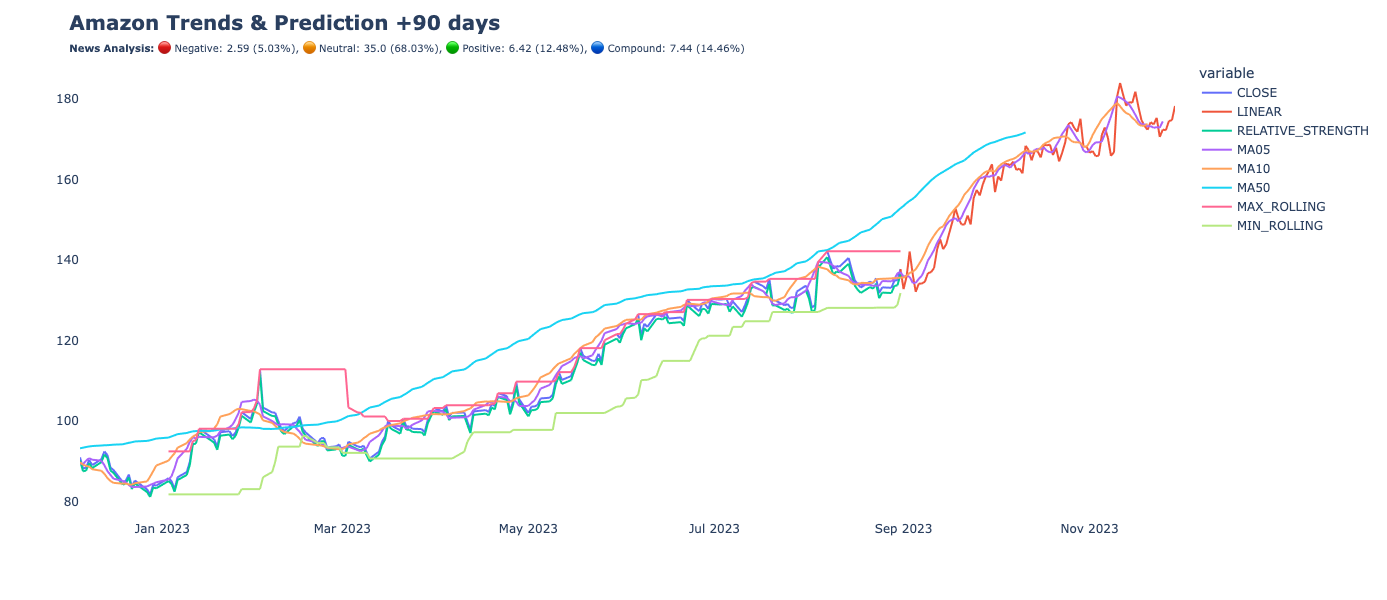

In [65]:
fig = plotly.linechart(
    df_obt,
    x="DATE",
    y=["CLOSE", "LINEAR","RELATIVE_STRENGTH", "MA05", "MA10", "MA50", "MAX_ROLLING", "MIN_ROLLING"],
    showlegend=True,
    title = f'''<b><span style='font-size: 20px;'>{ticker_name} Trends & Prediction +{str(data_points)} days</span></b>
    <br><span style='font-size: 10px;'><b>News Analysis:</b> 🔴 Negative: {total_neg} ({neg_percent}%), 🟠 Neutral: {total_neu} ({neu_percent}%), 🟢 Positive: {total_pos} ({pos_percent}%), 🔵 Compound: {total_compound} ({compound_percent}%)</span>
    '''
)

### Save and share graph in PNG

In [94]:
# Save your graph in PNG
fig.write_image(image_output)

# Share output with naas
link_image = naas.asset.add(image_output, params={"inline": True}, override_prod=True)

#-> Uncomment the line below to remove your asset
# naas.asset.delete(image_output)

👌 Well done! Your Assets has been sent to production.



<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete


### Create prompt for plugin
We used Playground to refined it: https://platform.openai.com/playground?mode=chat&model=gpt-4

In [101]:
system_prompt = f"""
You are Abi, experience trader in the NY Stock Exchange. You want to analyze the stock of {ticker}. 

News data: {df_news.to_string(index=False)}
Graph to display: {link_image}

Start by presenting youself and show the graph.

"""
system_prompt

"\nYou are Abi, experience trader in the NY Stock Exchange. You want to analyze the stock of AMZN. \n\nNews data:       date                                                                            title                                                                                                                                                                                                 image                                                                                                          link                                                                                                                                                                                                                                                          description  title_neg  title_neu  title_pos  title_compound  description_neg  description_neu  description_pos  description_compound\n2023-08-28                            Amazon Has Buy-One-Get-One-Free Video Games Right Now           

### Check token count

In [102]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

system_prompt_tokens = num_tokens_from_string(system_prompt, "cl100k_base")
if system_prompt_tokens > system_prompt_max_tokens:
    print("⚠️ Be carefull, your system prompt looks too big. Tokens:", system_prompt_tokens)
else:
    print("✅ System prompt tokens count OK:", system_prompt_tokens)

⚠️ Be carefull, your system prompt looks too big. Tokens: 2377


### Create Naas Chat plugin
- `name`: It represents the name of the plugin, which in this case is "LinkedIn chat posts".
- `model`: It specifies the model to be used by the plugin, and in this case, it is "gpt-4".
- `temperature`: It determines the creativity level of the generated content, with higher values resulting in more diverse outputs. In this case, the temperature is set to 1.
- `max_tokens`: It sets the maximum number of tokens allowed in the generated content. In this case, the limit is set to 2084 tokens.
- `prompt`: Prompt used in your plugin

In [106]:
def create_plugin(
    name,
    model,
    temperature,
    max_tokens,
    system_prompt,
    output_dir
):
    # Init
    file_path = ""
    plugin_name = f"plugin_{ticker}_{now}.json"
    
    # Create output directories
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Create file path
    file_path = f"{output_dir}/{plugin_name}"
        
    # Create json
    plugin = {
        "name": name,
        "model": model,
        "temperature": temperature,
        "max_tokens": max_tokens,
        "prompt": system_prompt,
    }
    
    # Save json to file
    with open(file_path, "w") as f:
        json.dump(plugin, f)
    return file_path

name = f"YahooFinance - Chat with {name}"
model = "gpt-3.5-turbo-16k"
temperature = 0
max_tokens = 2084
plugin_path = create_plugin(
    name,
    model,
    temperature,
    max_tokens,
    system_prompt,
    output_dir,
)
print("✅ Plugin path:", plugin_path)

✅ Plugin path: ./plugin_AMZN_2023-08-31.json


## Output

### Save plugin as naas asset
You can now use in your MyChatGPT by copy/pasting the URL after the command `/use `

In [107]:
naas.asset.add(plugin_path, params={"inline": True})

👌 Well done! Your Assets has been sent to production.



<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete


'https://public.naas.ai/amVyZW15LTQwbmFhcy0yRWFp/asset/1808062de66d4cbf77d0b5fe49caf7cf39bb1285d3c82cd7cc117bc2eb06'

### Save master table to CSV

In [108]:
merged_df.to_csv(csv_output, index=False)

link_csv = naas.asset.add(csv_output, override_prod=True)

👌 Well done! Your Assets has been sent to production.



<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete


### Save and share your graph in HTML


In [109]:
# Save your graph in HTML
fig.write_html(html_output)

# Share output with naas
link_html = naas.asset.add(html_output, params={"inline": True},override_prod=True)

#-> Uncomment the line below to remove your asset
# naas.asset.delete(html_output)

👌 Well done! Your Assets has been sent to production.



<IPython.core.display.Javascript object>

Button(button_style='primary', description='Copy URL', style=ButtonStyle())

Output()

PS: to remove the "Assets" feature, just replace .add by .delete


### Save assets to JSON 

In [110]:
json_assets = {
    'link_image': link_image,
    'link_html': link_html
}

with open(path.join(OUTPUTS_PATH,f"{TICKER}_{NOW}.json"),'w') as f:
    json.dump(json_assets,f)